In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# External imports 
import torch
from torch.utils.data import DataLoader
from torch.distributions.mixture_same_family import MixtureSameFamily
import torch.distributions as D
import random
import numpy as np
from tqdm import trange
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

# Internal imports
import sys; sys.path.insert(0, '..')
from src import *

In [3]:
N_DIMS = 1
NUM_SAMPLES = 33000
BS = 500
NUM_EPOCHS = 500
SEED = 10
LR = 1e-2
DROPOUT = 0.20
DEVICE = 'cuda:1' if torch.cuda.is_available() else 'cpu'


# Break by changing num datapoints, scales, means, or to 2D

In [4]:
# Setting seed for reproducibility
random.seed(SEED)
torch.manual_seed(SEED)
np.random.seed(SEED)

In [5]:
# Define model
model_cob = RatioCritic1D(dim_input=N_DIMS, dim_output=3, dropout=DROPOUT)
# model.apply(weights_init)

# Define optimizer
optim_cob = torch.optim.Adam(model_cob.parameters(), lr=LR)

# Define distributions
p, q, m = get_dists_1d(mu1=-1., mu2=1., mu3=0, scale_p=0.1, scale_q=0.2, scale_m=1.0)

# -5, 5, m_var=3.0
# -10, 10, m_var=3.0

In [ ]:
# p_samples = p.sample([1000])
# q_samples = q.sample([1000])
# m1_samples = m1.sample([1000])
# m2_samples = m2.sample([1000])
# m3_samples = m3.sample([1000])

# plt.hist(p_samples.numpy(), density=True, histtype='stepfilled')
# plt.hist(q_samples.numpy(), density=True, histtype='stepfilled')
# plt.hist(m1_samples.numpy(), density=True, histtype='stepfilled')
# plt.hist(m2_samples.numpy(), density=True, histtype='stepfilled')
# plt.hist(m3_samples.numpy(), density=True, histtype='stepfilled')
# plt.show()

In [ ]:
# # Combine all m distributions into a mixture
# m = MixtureSameFamily(
#     D.Categorical(torch.Tensor([0.33, 0.33, 0.33])),
#     D.Independent(D.Normal(torch.Tensor([m1.loc, m2.loc, m3.loc]), torch.Tensor([m1.scale, m2.scale, m3.scale])),0))

In [7]:
# Define dataset & dataloader
train_ds = DistDataset(p, q, m, num_samples=NUM_SAMPLES)
test_ds = DistDataset(p, q, m, num_samples=NUM_SAMPLES) # Test dataset is only of size batch 

Sampling p
Sampling q
Cauchy(loc: 0.0, scale: 1.0)
Sampling m
torch.Size([33000])
torch.Size([33000])
torch.Size([33000])
Sampling p
Sampling q
Cauchy(loc: 0.0, scale: 1.0)
Sampling m
torch.Size([33000])
torch.Size([33000])
torch.Size([33000])


In [8]:
# Define dataloader
train_dl = DataLoader(train_ds, batch_size=BS, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=BS, shuffle=True)

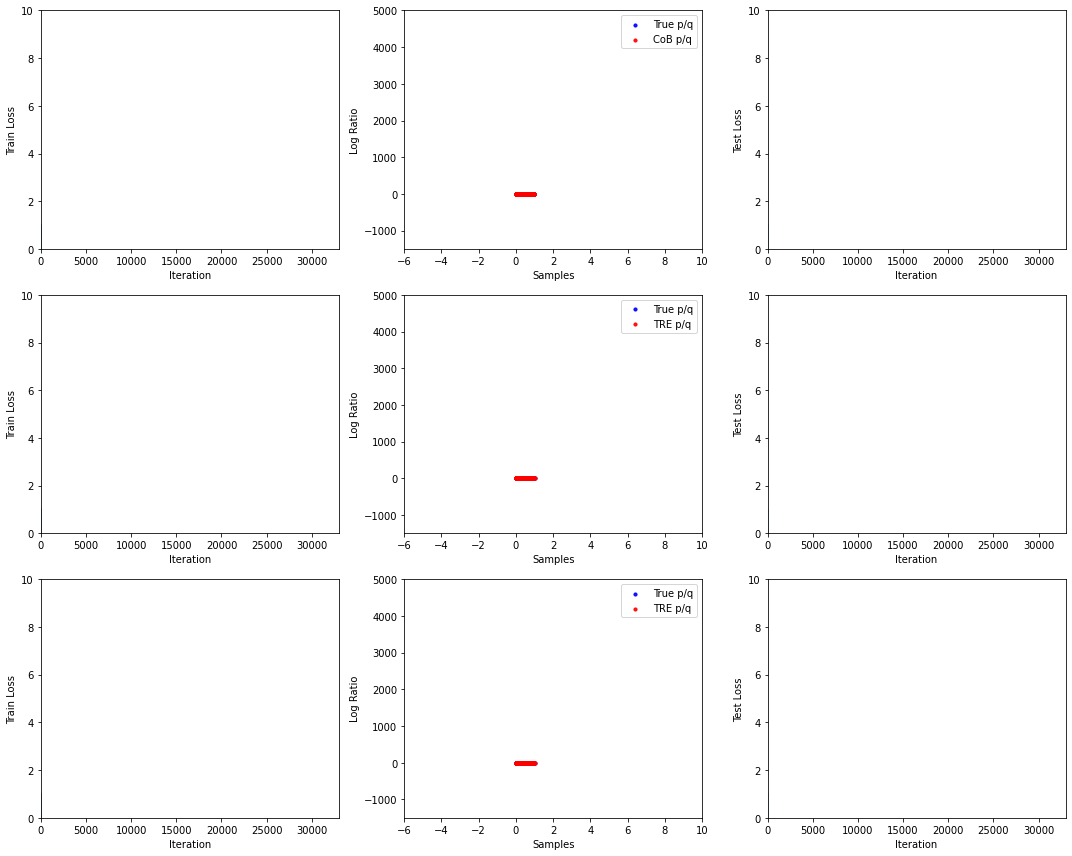

In [9]:
# Set up viz
fig, [[ax1,ax2,ax3], [ax4, ax5, ax6], [ax7, ax8, ax9]] = plt.subplots(3, 3,figsize=(15,12))

line, = ax1.plot([0,1],[0,1])
x, y = np.random.random((2, 500))
scat1 = ax2.scatter(x,y,label='True p/q',alpha=0.9,s=10.,c='b')
scat2 = ax2.scatter(x,y,label='CoB p/q',alpha=0.9,s=10.,c='r')
test_line, = ax3.plot([0,1],[0,1])

ax1.set_xlabel("Iteration")
ax1.set_ylabel("Train Loss")
ax1.set_xlim([0,NUM_EPOCHS*NUM_SAMPLES//BS])
ax1.set_ylim([0,10])

ax2.set_xlabel("Samples")
ax2.set_ylabel("Log Ratio")
ax2.legend(loc='best')
ax2.set_xlim([-6,10])
ax2.set_ylim([-1500,5000])

ax3.set_xlabel("Iteration")
ax3.set_ylabel("Test Loss")
ax3.set_xlim([0,NUM_EPOCHS*NUM_SAMPLES//BS])
ax3.set_ylim([0,10])

line2, = ax4.plot([0,1],[0,1])
x, y = np.random.random((2, 500))
scat3 = ax5.scatter(x,y,label='True p/q',alpha=0.9,s=10.,c='b')
scat4 = ax5.scatter(x,y,label='TRE p/q',alpha=0.9,s=10.,c='r')
test_line2, = ax6.plot([0,1],[0,1])

ax4.set_xlabel("Iteration")
ax4.set_ylabel("Train Loss")
ax4.set_xlim([0,NUM_EPOCHS*NUM_SAMPLES//BS])
ax4.set_ylim([0,10])

ax5.set_xlabel("Samples")
ax5.set_ylabel("Log Ratio")
ax5.legend(loc='best')
ax5.set_xlim([-6,10])
ax5.set_ylim([-1500,5000])

ax6.set_xlabel("Iteration")
ax6.set_ylabel("Test Loss")
ax6.set_xlim([0,NUM_EPOCHS*NUM_SAMPLES//BS])
ax6.set_ylim([0,10])


line3, = ax7.plot([0,1],[0,1])
scat5 = ax8.scatter(x,y,label='True p/q',alpha=0.9,s=10.,c='b')
scat6 = ax8.scatter(x,y,label='TRE p/q',alpha=0.9,s=10.,c='r')
test_line3, = ax9.plot([0,1],[0,1])

ax7.set_xlabel("Iteration")
ax7.set_ylabel("Train Loss")
ax7.set_xlim([0,NUM_EPOCHS*NUM_SAMPLES//BS])
ax7.set_ylim([0,10])

ax8.set_xlabel("Samples")
ax8.set_ylabel("Log Ratio")
ax8.legend(loc='best')
ax8.set_xlim([-6,10])
ax8.set_ylim([-1500,5000])

ax9.set_xlabel("Iteration")
ax9.set_ylabel("Test Loss")
ax9.set_xlim([0,NUM_EPOCHS*NUM_SAMPLES//BS])
ax9.set_ylim([0,10])

plt.tight_layout()

loss_store = []
test_loss_store = []

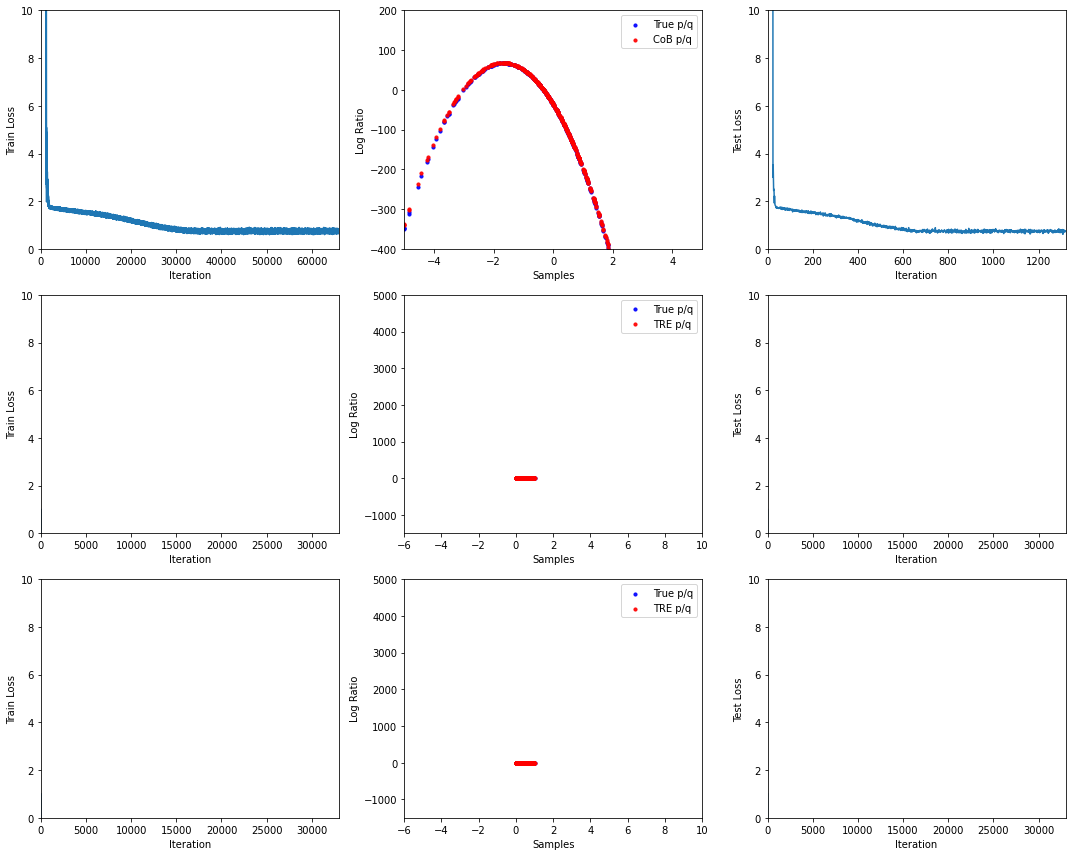

100%|██████████| 500/500 [19:06<00:00,  2.29s/it]


In [11]:
## CONFIRM q_list_test in validation/visualization in Akash's code

model_cob.train()

if torch.cuda.is_available():
    model_cob = model_cob.to(DEVICE)
    
i = 0
# loss_crit = torch.nn.CrossEntropyLoss()
loss_crit_cob = torch.nn.functional.cross_entropy


for epoch in trange(NUM_EPOCHS):
    for p_batch, q_batch, m_batch in iter(train_dl):
        model_cob.train()
        
        i += 1
        
        optim_cob.zero_grad()
        
        # CUDA
        if torch.cuda.is_available():
            p_batch, q_batch, m_batch = p_batch.unsqueeze(1).to(DEVICE), q_batch.unsqueeze(1).to(DEVICE), m_batch.unsqueeze(1).to(DEVICE)
            
        logP = model_cob(p_batch)
        logQ = model_cob(q_batch)
        logM = model_cob(m_batch)
        
        p_label = torch.empty(p_batch.shape[0], dtype=torch.long, device=DEVICE).fill_(0)
        q_label = torch.empty(q_batch.shape[0], dtype=torch.long, device=DEVICE).fill_(1)
        m_label = torch.empty(m_batch.shape[0], dtype=torch.long, device=DEVICE).fill_(2)
        
        loss_cob = loss_crit_cob(logP, p_label) + loss_crit_cob(logQ, q_label) + loss_crit_cob(logM, m_label)
        loss_cob.backward()
        optim_cob.step()
        loss_store.append(loss_cob.item())

        # Validation/Test
        if i % 50 == 0:
            model_cob.eval()
            
            with torch.no_grad():
                for p_batch, q_batch, m_batch in iter(test_dl):
                    gt_log_ratio_p_q, _, true_kl_p_q = get_gt_ratio_kl(p, q, m_batch, calc_true_kl=True)

                    if torch.cuda.is_available():
                        p_batch, q_batch, m_batch = p_batch.unsqueeze(1).to(DEVICE), q_batch.unsqueeze(1).to(DEVICE), m_batch.unsqueeze(1).to(DEVICE)
                    
                    logP = model_cob(p_batch)
                    logQ = model_cob(q_batch)
                    logM = model_cob(m_batch)

#                     log_ratio_p_q_from_cob = logP[:, 0] - logP[:, 1]
#                     kl_from_cob = torch.mean(log_ratio_p_q_from_cob)
                    
                    log_ratio_p_q_from_cob = logM[:, 0] - logM[:, 1]

                    p_label = torch.empty(p_batch.shape[0], dtype=torch.long, device=DEVICE).fill_(0)
                    q_label = torch.empty(q_batch.shape[0], dtype=torch.long, device=DEVICE).fill_(1)
                    m_label = torch.empty(m_batch.shape[0], dtype=torch.long, device=DEVICE).fill_(2)
                    
                    test_loss_cob = loss_crit_cob(logP, p_label) + loss_crit_cob(logQ, q_label) + loss_crit_cob(logM, m_label)

                    # Visualize
                    line.set_data(range(len(loss_store)), loss_store)
                    ax1.set_xlim( 0, len(loss_store) )
                    
                    scat1.set_offsets(np.vstack([m_batch.cpu().squeeze(), gt_log_ratio_p_q.cpu().detach()]).T)
                    scat2.set_offsets(np.vstack([m_batch.cpu().squeeze(), log_ratio_p_q_from_cob.cpu().detach()]).T)

                    ax2.set_xlim( -5., 5. )
                    ax2.set_ylim( -400, 200)
            
                    test_loss_store.append(test_loss_cob.item())
                    test_line.set_data(range(len(test_loss_store)), test_loss_store)
                    ax3.set_xlim( 0, len(test_loss_store) )
                    
                    clear_output(wait=True)
                    display(fig)
                    break

            model_cob.train()

In [ ]:
                    print('iteration: ',i)
                    print('KLD: ', true_kl_p_q)
                    print('CoB: ', kl_from_cob)

In [12]:
def get_gt_log_ratios(p, q, m1, samples):
    p_lp = p.log_prob(samples.cpu())
    q_lp = q.log_prob(samples.cpu())
    m1_lp = m1.log_prob(samples.cpu())
#     m2_lp = m2.log_prob(samples.cpu())
#     m3_lp = m3.log_prob(samples.cpu())
    
#     return p_lp - q_lp,  p_lp - m1_lp, m1_lp - m2_lp, m2_lp - m3_lp, m3_lp - q_lp #p_lp - m_lp, q_lp - m_lp, m_lp - q_lp # p/q, p/m, q/m, m/q
    return p_lp - q_lp #, p_lp - m2_lp, q_lp - m2_lp, m1_lp - m2_lp, m3_lp - m2_lp
    
    

In [19]:
#######
with torch.no_grad():
    model_cob.eval()
    for p_batch, q_batch, m_batch1 in iter(test_dl):
        if torch.cuda.is_available():
            p_batch, q_batch, m_batch1 = p_batch.unsqueeze(1).to(DEVICE), q_batch.unsqueeze(1).to(DEVICE), m_batch1.unsqueeze(1).to(DEVICE)


#         p_batch = torch.from_numpy(np.linspace(-1.5, 1.5, 1000)).unsqueeze(1).to(DEVICE)

        logP1 = model_cob(p_batch).cpu()
        log_ratio_p_q_from_p= logP1[:, 0] - logP1[:, 1]
        
        logP2 = model_cob(m_batch1).cpu()
        log_ratio_p_q_from_m1 = logP2[:, 0] - logP2[:, 1]
        
        logP3 = model_cob(q_batch).cpu()
        log_ratio_p_q_from_q = logP3[:, 0] - logP3[:, 1]
        
        true_log_ratio_p_q_from_p = get_gt_log_ratios(p, q, m, p_batch)
        true_log_ratio_p_q_from_m1 = get_gt_log_ratios(p, q, m, m_batch1)
        true_log_ratio_p_q_from_q = get_gt_log_ratios(p, q, m, q_batch)
        break

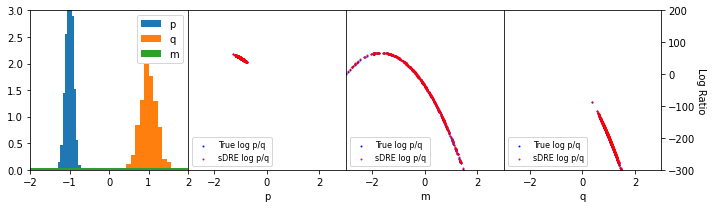

In [75]:
# Set up viz
fig, [ax4, ax1,ax2,ax3] = plt.subplots(1, 4,figsize=(10,3))
p_batch = p_batch.cpu()

p_samples = p.sample([1000])
q_samples = q.sample([1000])
m_samples= m.sample([1000])

ax4.hist(p_samples.numpy(), density=True, histtype='stepfilled', label='p')
ax4.hist(q_samples.numpy(), density=True, histtype='stepfilled', label='q')
ax4.hist(m_samples.numpy(), density=True, histtype='stepfilled', label='m')



scat1 = ax1.scatter(p_batch,true_log_ratio_p_q_from_p,label='True log p/q',alpha=0.9,s=1.,c='b')
scat2 = ax1.scatter(p_batch,log_ratio_p_q_from_p,label='sDRE log p/q',alpha=0.9,s=1.,c='r')

scat3 = ax2.scatter(m_batch1.cpu(),true_log_ratio_p_q_from_m1,label='True log p/q',alpha=0.9,s=1.,c='b')
scat4 = ax2.scatter(m_batch1.cpu(),log_ratio_p_q_from_m1,label='sDRE log p/q',alpha=0.9,s=1.,c='r')

scat5 = ax3.scatter(q_batch.cpu(),true_log_ratio_p_q_from_q,label='True log p/q',alpha=0.9,s=1.,c='b')
scat6 = ax3.scatter(q_batch.cpu(),log_ratio_p_q_from_q,label='sDRE log p/q',alpha=0.9,s=1.,c='r')

ylim = [-300, 200]
xlim = [-3, 3]

ax1.set_ylabel("Log Ratio")
ax1.legend(loc='lower left', prop={'size': 8})
ax1.set_xlim(xlim)
ax1.set_ylim(ylim)
ax1.set_xlabel('p')

ax2.set_ylabel("Log Ratio")
ax2.legend(loc='lower left', prop={'size': 8})
ax2.set_xlim(xlim)
ax2.set_ylim(ylim)
ax2.set_xlabel('m')

ax3.set_ylabel("Log Ratio", rotation=270, labelpad=10)
ax3.legend(loc='lower left', prop={'size': 8})
ax3.set_xlim(xlim)
ax3.set_ylim(ylim)
ax3.set_xlabel('q')
ax3.yaxis.tick_right()
ax3.yaxis.set_label_position("right")


ax4.set_xlim([-2,2])
ax4.set_ylim([0, 3])
ax4.legend()


ax1.get_yaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)

plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0.0)

plt.savefig('1D_demo_cob_K=1_cauchy_logpq.png')

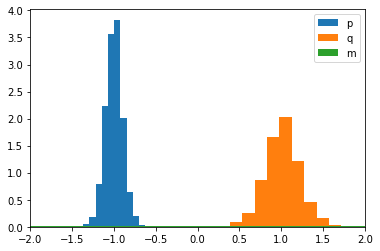

In [40]:
fig, ax = plt.subplots()
ax.hist(p_samples.numpy(), density=True, histtype='stepfilled', label='p')
ax.hist(q_samples.numpy(), density=True, histtype='stepfilled', label='q')
ax.hist(m_samples.numpy(), density=True, histtype='stepfilled', label='m')
ax.set_xlim([-2,2])
ax.legend()